In [2]:
# !pip install catboost

Hello. My name is Alexey.
I used several machine learning models in my work.
Best result on Catboost Resgressor = 5.023.

# Traffic forecast in the metropolis

## Data preparation

For the March edition of the 2022 Tabular Playground Series you're challenged to forecast twelve-hours of traffic flow in a U.S. metropolis. The time series in this dataset are labelled with both location coordinates and a direction of travel -- a combination of features that will test your skill at spatio-temporal forecasting within a highly dynamic traffic network.

Which model will prevail? The venerable linear regression? The deservedly-popular ensemble of decision trees? Or maybe a cutting-edge graph neural-network? We can't wait to see!

In [3]:
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Exploring Files

Files and Field Descriptions:  
`train.csv` - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.  
- `row_id` - a unique identifier for this instance  
- `time` - the 20-minute period in which each measurement was taken  
- `x` - the east-west midpoint coordinate of the roadway  
- `y` - the north-south midpoint coordinate of the roadway  
- `direction` - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.  
- `congestion` - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.  

`test.csv` - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.  

In [4]:
df_train = pd.read_csv(r"/content/train.csv")

In [5]:
df_train.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   row_id      848835 non-null  int64 
 1   time        848835 non-null  object
 2   x           848835 non-null  int64 
 3   y           848835 non-null  int64 
 4   direction   848835 non-null  object
 5   congestion  848835 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 38.9+ MB


In [7]:
df_test = pd.read_csv(r"/content/test.csv")

In [8]:
df_test.head()

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   row_id     2340 non-null   int64 
 1   time       2340 non-null   object
 2   x          2340 non-null   int64 
 3   y          2340 non-null   int64 
 4   direction  2340 non-null   object
dtypes: int64(3), object(2)
memory usage: 91.5+ KB


### Feature engineering

In [10]:
def feature_engineering(data):
    data['time'] = pd.to_datetime(data['time'])
    data['weekday'] = data['time'].dt.weekday
    data['hour'] = data['time'].dt.hour
    data['minute'] = data['time'].dt.minute
    return data

In [11]:
for data in df_train:
    data = feature_engineering(df_train)

In [12]:
for data in df_test:
    data = feature_engineering(df_test)

### Data preprocessing

In [13]:
df_train = df_train.drop(columns='row_id')
df_train = df_train.drop(columns='time')

df_train = pd.get_dummies(df_train, drop_first=True)

In [14]:
df_test = df_test.drop(columns='time')
df_test = pd.get_dummies(df_test, drop_first=True)

In [15]:
features_train = df_train.drop('congestion', axis=1)
target_train = df_train['congestion']

In [16]:
features_train, features_valid = train_test_split(features_train, test_size=0.25, random_state=12345)
target_train, target_valid = train_test_split(target_train, test_size=0.25, random_state=12345)
features_test = df_test.drop(columns='row_id')

## Data analysis

### Train features

In [17]:
features_train.head()

,x,y,weekday,hour,minute,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB
606969,2,3,4,0,40,0,0,0,0,0,0,1
426916,2,3,0,11,40,0,1,0,0,0,0,0
611618,1,3,5,0,40,0,0,0,0,0,0,0
708270,1,2,4,22,20,0,0,0,1,0,0,0
198118,2,3,0,12,20,0,0,0,0,0,1,0


In [18]:
features_valid.head()

,x,y,weekday,hour,minute,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB
548072,2,2,5,10,0,0,0,0,0,0,1,0
646334,2,0,5,11,20,0,0,0,0,0,0,0
485489,0,1,6,0,20,1,0,0,0,0,0,0
356339,0,2,6,10,0,0,0,0,1,0,0,0
505036,2,2,3,4,20,0,0,0,0,0,0,0


In [19]:
features_test.head()

,x,y,weekday,hour,minute,direction_NB,direction_NE,direction_NW,direction_SB,direction_SE,direction_SW,direction_WB
0,0,0,0,12,0,0,0,0,0,0,0,0
1,0,0,0,12,0,1,0,0,0,0,0,0
2,0,0,0,12,0,0,0,0,1,0,0,0
3,0,1,0,12,0,0,0,0,0,0,0,0
4,0,1,0,12,0,1,0,0,0,0,0,0


In [20]:
features_train['x'].value_counts()

2    254715
1    215601
0    166310
Name: x, dtype: int64

In [21]:
features_train['y'].value_counts()

2    176299
3    176246
1    156608
0    127473
Name: y, dtype: int64

### Target feature

In [22]:
df_train['congestion'].value_counts()

34    26498
40    19797
47    19418
29    19236
48    19013
      ...  
95      140
97      104
98       87
1        48
99       42
Name: congestion, Length: 101, dtype: int64

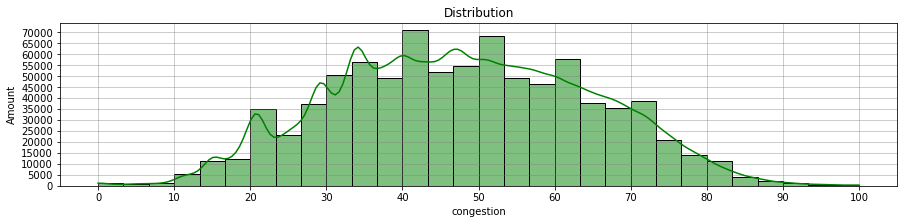

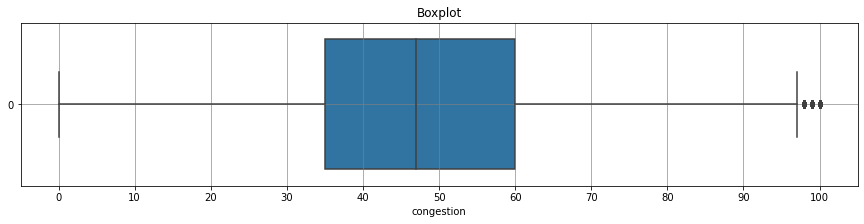

In [23]:
plt.figure(figsize=(15, 3))
sns.histplot(data=df_train, x='congestion', kde=True, bins=30, color='green')

plt.title(f'Distribution')
plt.ylabel('Amount')
plt.xlabel('congestion')
plt.grid(color='grey', axis='both', alpha=0.5)
plt.xticks(np.arange(0, 105, 10))
plt.yticks(np.arange(0, 75000, 5000))
plt.show()

plt.rcParams['figure.figsize']=(15, 3)
sns.boxplot( data=df_train['congestion'], orient="h" )
plt.title(f'Boxplot')
plt.xlabel('congestion')
plt.grid(color='grey', axis='both', alpha=.8)
plt.xticks(np.arange(0, 105, 10))
plt.show()

### Feature correlation 

Text(0.5, 1.0, 'Correlation Heatmap')

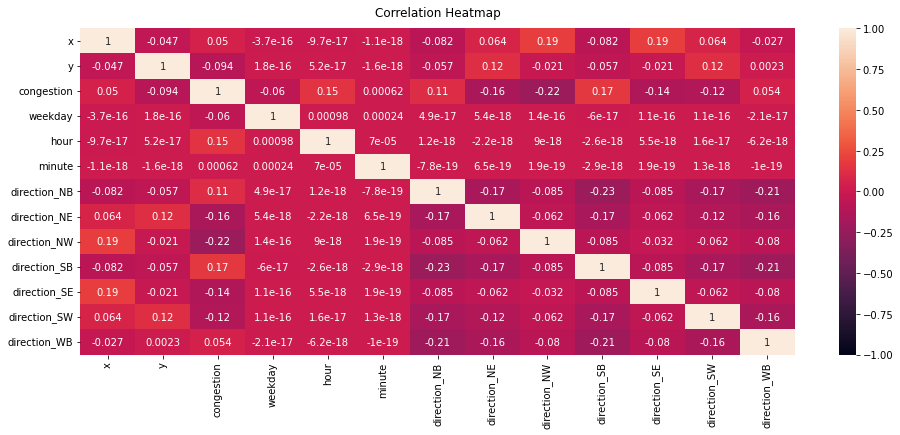

In [24]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

## Train and validate models

### Random forest regressor

In [ ]:
%%time


rf = RandomForestRegressor(random_state=123)

params = {'n_estimators': [100, 150, 250, 300],
          'max_depth': [5, 7, 9, 15, 20],
          'min_samples_leaf' : [1, 2],
          'max_features':['auto'],
          'min_samples_split': [2, 4],
          }

cv_rfc_model = GridSearchCV(estimator=rf, param_grid=params, n_jobs=-1, cv=5)

cv_rfc_model.fit(features_train, target_train)

In [ ]:
cv_rfc_model.best_params_

In [25]:
rfc_best_model = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=123)
rfc_best_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=123)

In [26]:
predictions_valid = rfc_best_model.predict(features_valid)

In [27]:
mean_absolute_error(target_valid, predictions_valid)

6.336206914693241

### Extreme gradient boosting regressor

In [ ]:
%%time


exg = xgb.XGBRegressor(verbosity=0, random_state=123)

params = {'n_estimators': [100, 150, 200, 300]}

cv_exg_model = GridSearchCV(estimator=exg, param_grid=params, n_jobs=10, cv=10)

cv_exg_model.fit(features_train, target_train)

In [ ]:
cv_exg_model.best_params_

In [ ]:
predictions_valid_exg = cv_exg_model.predict(features_valid)

In [ ]:
mean_absolute_error(target_valid, predictions_valid_exg)

### Linear regression

In [28]:
lr_best_model = LinearRegression()
lr_best_model.fit(features_train, target_train)

LinearRegression()

In [29]:
predictions_valid_exg = lr_best_model.predict(features_valid)

In [30]:
mean_absolute_error(target_valid, predictions_valid_exg)

12.166671386125127

### Cat boost regressor

In [ ]:
CBR = CatBoostRegressor()

parameters = {'verbose' : [25, 50, 100],
              'early_stopping_rounds' : [5, 10],
              'random_seed' : [1000, 2000],
              'max_depth' : [5, 10 ,15],
              'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05],
              'iterations' :  [100, 250, 500],
              'loss_function' : ['MAE'],
              'eval_metric' : ['MAE'],
             }

Grid_CBC = GridSearchCV(estimator=CBR, param_grid=parameters, cv=5, n_jobs=-1)
Grid_CBC.fit(features_train, target_train)

In [ ]:
Grid_CBC.best_params_

In [31]:
cbr_best_model = CatBoostRegressor(early_stopping_rounds=5, eval_metric='MAE', 
                                   iterations=500, learning_rate=0.05, loss_function='MAE', 
                                   max_depth=15, random_seed=2000, verbose=25
                                   )

cbr_best_model.fit(features_train, target_train)

0:	learn: 13.3890883	total: 177ms	remaining: 1m 28s
25:	learn: 7.7855386	total: 3.12s	remaining: 56.9s
50:	learn: 6.8179240	total: 6.06s	remaining: 53.4s
75:	learn: 6.5690001	total: 8.93s	remaining: 49.8s
100:	learn: 6.4761201	total: 11.6s	remaining: 45.7s
125:	learn: 6.4217848	total: 14.1s	remaining: 42s
150:	learn: 6.3864344	total: 16.7s	remaining: 38.6s
175:	learn: 6.3629610	total: 19.1s	remaining: 35.1s
200:	learn: 6.3428902	total: 21.6s	remaining: 32.1s
225:	learn: 6.3344006	total: 23.6s	remaining: 28.6s
250:	learn: 6.3226016	total: 25.9s	remaining: 25.7s
275:	learn: 6.3140849	total: 28.2s	remaining: 22.9s
300:	learn: 6.3075299	total: 30.9s	remaining: 20.4s
325:	learn: 6.3013137	total: 33.7s	remaining: 18s
350:	learn: 6.2892274	total: 36.5s	remaining: 15.5s
375:	learn: 6.2484090	total: 39.3s	remaining: 13s
400:	learn: 6.2372239	total: 42s	remaining: 10.4s
425:	learn: 6.2301492	total: 44.7s	remaining: 7.77s
450:	learn: 6.2214531	total: 47.5s	remaining: 5.16s
475:	learn: 6.2178913	t

In [32]:
predictions_valid = cbr_best_model.predict(features_valid)

In [33]:
mean_absolute_error(target_valid, predictions_valid)

6.293241136731521

## Test of the best models

In [34]:
features_test = df_test.drop('row_id', axis=1)

In [35]:
df_test['congestion'] = list(rfc_best_model.predict(features_test))

### Random forest regressor prediction


In [ ]:
df_test['congestion'] = list(rfc_best_model.predict(features_test))
df_test = df_test[['row_id', 'congestion']]
df_test.to_csv(r"/content/rfc_best_model.csv", index=False)
df_test.head()

### Catboost regressor prediction

In [ ]:
df_test['congestion'] = list(cbr_best_model.predict(features_test))
df_test = df_test[['row_id', 'congestion']]
df_test.to_csv(r"/content/cbr_best_model.csv", index=False)
df_test.head()

## General conclusion

In [ ]:
# MAE 1 score: 5.137 (my in collab 6.771626217607527) - XGBRe
# MAE 2 score: 5.096 (my in collab 6.728822236988457) - RandomForestRegressor
# MAE 3 score: 5.219 (my in collab 6.436506568386449) - XGBReScore: 
# MAE 4 score: 5.198 (my in collab 6.312052246252551) - XGBReScore: 
# MAE 5 score: 5.023 (my in collab 6.293241136731521) - CBR + GridSearch: 

**Results:**

1. `Cat boost regressor`:  
Mean absolute error = 6.293, Kaggle MAE = 5.023;

2. `Random forest regressor`:  
Mean absolute error = 6.336, Kaggle MAE = 5.096;

3. `Extreme gradient boosting regressor`:  
Mean absolute error = 6.436, Kaggle MAE = 5.198;

4. `Linear regression`:  
Mean absolute error = 12.166, Kaggle MAE = 14.456.